In [ ]:
%load_ext autoreload
%autoreload 2

import os
from pathlib import Path

import matplotlib
import matplotlib.pyplot as plt
import mne
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.formula.api as smf
from mne import EvokedArray
from mne.datasets import fetch_fsaverage
from scipy import stats
from scipy.stats import ttest_1samp, ttest_rel
from scipy.stats.distributions import chi2
from statsmodels.stats.anova import AnovaRM, anova_lm
from statsmodels.stats.multitest import multipletests
from vr2f.decoding import plotters
from vr2f.staticinfo import COLORS, PATHS, TIMINGS
from vr2f.utils.stats import l2norm

In [6]:
# Setup:
matplotlib.rcParams["pdf.fonttype"] = 42
matplotlib.rcParams["ps.fonttype"] = 42
matplotlib.rcParams.update({"font.size": 16})
cm = 1 / 2.54

# Parameters:
alpha_lvl = 0.05
p_val_cbp = 0.05

# Paths:
paths = PATHS()
path_in = Path(paths.DATA_03_AR, "cleaneddata")

# load data
sub_list_str = [s.split("-postAR-epo")[0] for s in os.listdir(path_in)]
# Sort it:
sub_list_str.sort()

## Multiclass decoding "emotion"

A classifier which distinguishes between the four emotional expressions (pooled across the two viewing conditions):

In [7]:
data_dict_allemos = plotters.load_decod_res_per_viewcond(
    sub_list_str=sub_list_str,
    conditions=["neutral", "happy", "angry", "surprised"],
    vc_list=["", "mono", "stereo"],
    scoring="roc_auc_ovr",
)
data_dict_allemos["all"] = data_dict_allemos.pop("")


Found 1 significant clusters for viewing condition 'all'.
Significant cluster: 94.000 - 1000.000


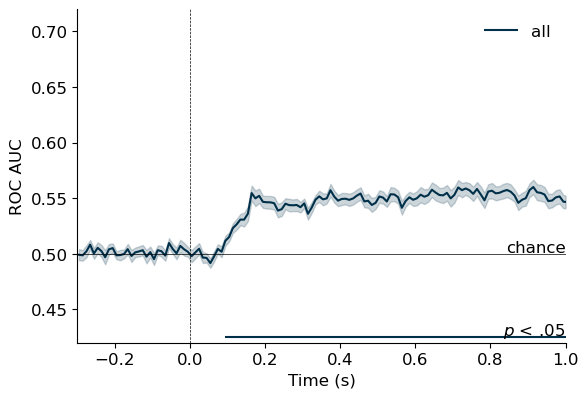

In [5]:
fig, ax = plt.subplots(1, figsize=(16 * cm, 11 * cm))
plotters.prep_and_plot_from_data(data_dict_allemos,
                        subsets=["all"],
                        ax=ax,
                        chancelvl=0.5,
                        ylims=(0.42, 0.72))



Now per viewing condition:

Found 1 significant clusters for viewing condition 'stereo'.
Significant cluster: 124.000 - 1000.000
Found 1 significant clusters for viewing condition 'mono'.
Significant cluster: 94.000 - 1000.000


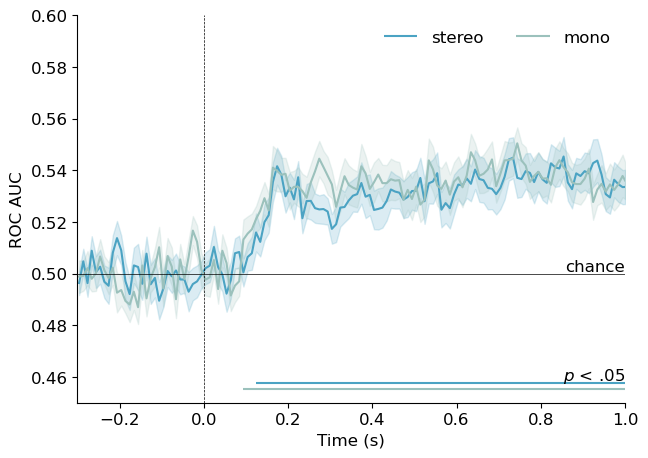

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(18.8 * cm, 13.3 * cm))

plotters.prep_and_plot_from_data(
    data_dict=data_dict_allemos,
    subsets=["stereo", "mono"],
    ax=ax,
    chancelvl=0.5,
    ylims=(0.45, 0.60),
)

fig.tight_layout()
fig.subplots_adjust(left=0.16, bottom=0.16, right=0.9, top=0.9)

fig.savefig(
    Path(paths.FIGURES, "decod_emo-all_mono-vs-stereo.pdf"),
    transparent=True,  # bbox_inches="tight"
)

Now we print the stats on the group level for the decoding per viewing condition:

In [6]:
# Overall:
print("All:")
_ = plotters.get_max_decod_score_and_time(data_dict_allemos["all"])
# Mono:
print("\nMono:")
_ = plotters.get_max_decod_score_and_time(data_dict_allemos["mono"])
print("\nStereo:")
_ = plotters.get_max_decod_score_and_time(data_dict_allemos["stereo"])

# run paired t-test:
df_mono = plotters.get_decod_df(data_dict_allemos["mono"])
df_stereo = plotters.get_decod_df(data_dict_allemos["stereo"])
t_peak_results = stats.ttest_rel(df_mono["peak"], df_stereo["peak"])
t_peak = t_peak_results.statistic
p_peak = t_peak_results.pvalue
df_peak = t_peak_results.df
print("\nStats (mono vs stereo):")
print(f"Peak stats (paired t test): t({df_peak}) = {t_peak:.2f}, p = {p_peak:.3f}")
t_peak_time_results = stats.ttest_rel(df_mono["peak_time"], df_stereo["peak_time"])
print(f"Peak time stats: t({t_peak_time_results.df}) = {t_peak_time_results.statistic:.2f}, "
      f"p = {t_peak_time_results.pvalue:.3f}")

All:
Peak mean: M = 0.61, SD = 0.03, 95% CI [0.60, 0.62]
Peak time: M = 414.00, SD = 315.81, 95% CI [306.25, 521.75]

Mono:
Peak mean: M = 0.61, SD = 0.02, 95% CI [0.60, 0.62]
Peak time: M = 384.00, SD = 287.71, 95% CI [285.83, 482.17]

Stereo:
Peak mean: M = 0.61, SD = 0.03, 95% CI [0.60, 0.62]
Peak time: M = 524.00, SD = 386.06, 95% CI [392.28, 655.72]

Stats (mono vs stereo):
Peak stats (paired t test): t(32) = -0.49, p = 0.627
Peak time stats: t(32) = -1.04, p = 0.305


# Binary contrasts

In the following we plot the decoding performance of the binary classifiers, contrasting the emotional expressions pairwise.


Contrast: angry vs neutral
Found 1 significant clusters for viewing condition 'all'.
Significant cluster: 114.000 - 1000.000

Contrast: angry vs happy
Found 1 significant clusters for viewing condition 'all'.
Significant cluster: 114.000 - 1000.000

Contrast: angry vs surprised
Found 5 significant clusters for viewing condition 'all'.
Significant cluster: 144.000 - 414.000
Significant cluster: 434.000 - 554.000
Significant cluster: 644.000 - 694.000
Significant cluster: 714.000 - 774.000
Significant cluster: 794.000 - 984.000

Contrast: happy vs neutral
Found 2 significant clusters for viewing condition 'all'.
Significant cluster: 104.000 - 134.000
Significant cluster: 174.000 - 1000.000

Contrast: happy vs surprised
Found 3 significant clusters for viewing condition 'all'.
Significant cluster: -266.000 - -246.000
Significant cluster: 94.000 - 144.000
Significant cluster: 164.000 - 1000.000

Contrast: surprised vs neutral
Found 2 significant clusters for viewing condition 'all'.
Signi

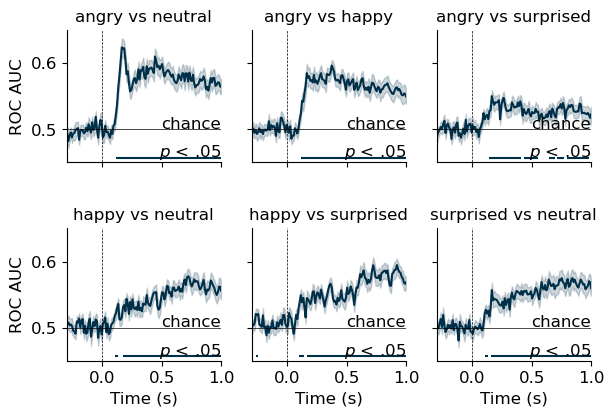

In [7]:
nrow = 2
ncol = 3
fig, ax_all = plt.subplots(nrow, ncol, figsize=(15.85*cm, 10*cm))
axs_ = ax_all.flatten()

binary_contrasts = [("angry", "neutral"),
                    ("angry", "happy"),
                    ("angry", "surprised"),
                    ("happy", "neutral"),
                    ("happy", "surprised"),
                    ("surprised", "neutral")]

for i, contrast in enumerate(binary_contrasts):

    print(f"\nContrast: {' vs '.join(contrast)}")

    data_dict_na = plotters.load_decod_res_per_viewcond(
        sub_list_str=sub_list_str,
        conditions=list(contrast),
        vc_list=[""],
        scoring="roc_auc_ovr",
    )
    data_dict_na["all"] = data_dict_na.pop("")

    plotters.prep_and_plot_from_data(data_dict_na,
                                     subsets=["all"],
                                     ax=axs_[i],
                                     chancelvl=0.5,
                                     ylims=(0.45, 0.65),
                                     show_legend=False,
                                     hide_xaxis_labs=i < (len(axs_) - ncol),
                                     hide_yaxis_labs=(i % ncol) > 0,
                                     nperm=10000,
                                     fontsize=12,
                                     )
    # add title:
    axs_[i].set_title(f"{' vs '.join(contrast)}", fontsize=12)

fig.subplots_adjust(left=0.08, bottom=0.08, right=0.92, top=0.92, wspace=0.2, hspace=0.5)

fig.savefig(
    Path(paths.FIGURES, "decod-perf_contrast-binary-all_vc-all.pdf"),
    transparent=True,  bbox_inches="tight"
)



Now we create the same figure, but plotting the decoding performance separately per viewing condition:


Contrast: angry vs neutral
Found 2 significant clusters for viewing condition 'mono'.
Significant cluster: 114.000 - 914.000
Significant cluster: 934.000 - 1000.000
Found 1 significant clusters for viewing condition 'stereo'.
Significant cluster: 124.000 - 1000.000

Contrast: angry vs happy
Found 1 significant clusters for viewing condition 'mono'.
Significant cluster: 144.000 - 954.000
Found 1 significant clusters for viewing condition 'stereo'.
Significant cluster: 124.000 - 1000.000

Contrast: angry vs surprised
Found 4 significant clusters for viewing condition 'mono'.
Significant cluster: 164.000 - 274.000
Significant cluster: 324.000 - 364.000
Significant cluster: 724.000 - 774.000
Significant cluster: 834.000 - 914.000
Found 2 significant clusters for viewing condition 'stereo'.
Significant cluster: 154.000 - 294.000
Significant cluster: 714.000 - 904.000

Contrast: happy vs neutral
Found 2 significant clusters for viewing condition 'mono'.
Significant cluster: 254.000 - 314.00

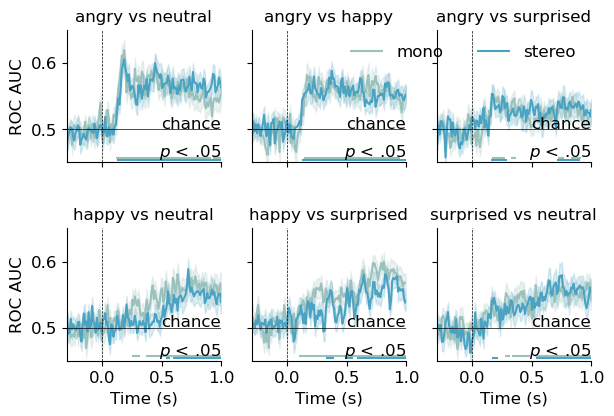

In [8]:
nrow = 2
ncol = 3
fig, ax_all = plt.subplots(nrow, ncol, figsize=(15.85*cm, 10*cm))
axs_ = ax_all.flatten()


for i, contrast in enumerate(binary_contrasts):

    print(f"\nContrast: {' vs '.join(contrast)}")

    data_dict_na = plotters.load_decod_res_per_viewcond(
        sub_list_str=sub_list_str,
        conditions=list(contrast),
        vc_list=["mono", "stereo"],
        scoring="roc_auc_ovr",
    )

    plotters.prep_and_plot_from_data(data_dict_na,
                                     subsets=["mono", "stereo"],
                                     ax=axs_[i],
                                     chancelvl=0.5,
                                     ylims=(0.45, 0.65),
                                     show_legend=i==nrow,
                                     hide_xaxis_labs=i < (len(axs_) - ncol),
                                     hide_yaxis_labs=(i % ncol) > 0,
                                     nperm=100,
                                     fontsize=12,
                                     )
    # add title:
    axs_[i].set_title(f"{' vs '.join(contrast)}", fontsize=12)


fig.tight_layout()
fig.subplots_adjust(left=0.08, bottom=0.08, right=0.92, top=0.92, wspace=0.2, hspace=0.5)

fig.savefig(
    Path(paths.FIGURES, "decod-perf_contrast-binary-all_vc-mono-stereo.pdf"),
    transparent=True,  bbox_inches="tight"
)

## Stats

Let's print the stats (peak performance and it's timing) for each contrast and viewing condition, and compare the veiwing conditions per contrast.

### Peak performance

In [9]:
plotters.print_table_contrasts(sub_list_str, "Peak")




Contrast: angry vs neutral

Mono:
Peak mean: M = 0.74, SD = 0.06, 95% CI [0.72, 0.76]
Peak time: M = 344.00, SD = 230.94, 95% CI [265.20, 422.80]

Stereo:
Peak mean: M = 0.74, SD = 0.05, 95% CI [0.72, 0.76]
Peak time: M = 454.00, SD = 363.03, 95% CI [330.14, 577.86]

Stats (mono vs stereo):
Peak stats (paired t test): t = 0.17, p = 0.869
Peak time stats: t = -0.89, p = 0.381



Contrast: angry vs happy

Mono:
Peak mean: M = 0.73, SD = 0.05, 95% CI [0.71, 0.74]
Peak time: M = 334.00, SD = 278.11, 95% CI [239.11, 428.89]

Stereo:
Peak mean: M = 0.72, SD = 0.06, 95% CI [0.70, 0.74]
Peak time: M = 344.00, SD = 307.00, 95% CI [239.25, 448.75]

Stats (mono vs stereo):
Peak stats (paired t test): t = 0.42, p = 0.679
Peak time stats: t = -0.59, p = 0.561



Contrast: angry vs surprised

Mono:
Peak mean: M = 0.70, SD = 0.04, 95% CI [0.69, 0.72]
Peak time: M = 184.00, SD = 311.88, 95% CI [77.59, 290.41]

Stereo:
Peak mean: M = 0.70, SD = 0.05, 95% CI [0.68, 0.71]
Peak time: M = 194.00, SD = 2

\begin{table}
\thcenter
\begin{tabular}{lcccccccc}
\toprule
 & \multicolumn{3}{c}{Mono} & \multicolumn{3}{c}{Stereo} & \multicolumn{2}{c}{Stats} \\
 & Mean & SD & CI & Mean & SD & CI & t(32) & p \\
\midrule
angry  vs  neutral & 0.74 & 0.06 & [0.72, 0.76] & 0.74 & 0.05 & [0.72, 0.76] & 0.17 & 0.869 \\
angry  vs  happy & 0.73 & 0.05 & [0.71, 0.74] & 0.72 & 0.06 & [0.70, 0.74] & 0.42 & 0.679 \\
angry  vs  surprised & 0.70 & 0.04 & [0.69, 0.72] & 0.70 & 0.05 & [0.68, 0.71] & 0.65 & 0.523 \\
happy  vs  neutral & 0.72 & 0.04 & [0.70, 0.73] & 0.70 & 0.05 & [0.69, 0.72] & 1.98 & 0.056 \\
happy  vs  surprised & 0.72 & 0.04 & [0.71, 0.74] & 0.71 & 0.05 & [0.69, 0.73] & 1.38 & 0.176 \\
surprised  vs  neutral & 0.72 & 0.05 & [0.70, 0.74] & 0.72 & 0.06 & [0.70, 0.74] & 0.23 & 0.821 \\
id1  vs  id2  vs  id3 & 0.60 & 0.02 & [0.60, 0.61] & 0.61 & 0.03 & [0.60, 0.62] & -1.44 & 0.159 \\
\bottomrule
\end{tabular}
\end{table}



### Peak performance time

In [10]:
plotters.print_table_contrasts(sub_list_str, "Time")




Contrast: angry vs neutral

Mono:
Peak mean: M = 0.74, SD = 0.06, 95% CI [0.72, 0.76]
Peak time: M = 344.00, SD = 230.94, 95% CI [265.20, 422.80]

Stereo:
Peak mean: M = 0.74, SD = 0.05, 95% CI [0.72, 0.76]
Peak time: M = 454.00, SD = 363.03, 95% CI [330.14, 577.86]

Stats (mono vs stereo):
Peak stats (paired t test): t = 0.17, p = 0.869
Peak time stats: t = -0.89, p = 0.381



Contrast: angry vs happy

Mono:
Peak mean: M = 0.73, SD = 0.05, 95% CI [0.71, 0.74]
Peak time: M = 334.00, SD = 278.11, 95% CI [239.11, 428.89]

Stereo:
Peak mean: M = 0.72, SD = 0.06, 95% CI [0.70, 0.74]
Peak time: M = 344.00, SD = 307.00, 95% CI [239.25, 448.75]

Stats (mono vs stereo):
Peak stats (paired t test): t = 0.42, p = 0.679
Peak time stats: t = -0.59, p = 0.561



Contrast: angry vs surprised

Mono:
Peak mean: M = 0.70, SD = 0.04, 95% CI [0.69, 0.72]
Peak time: M = 184.00, SD = 311.88, 95% CI [77.59, 290.41]

Stereo:
Peak mean: M = 0.70, SD = 0.05, 95% CI [0.68, 0.71]
Peak time: M = 194.00, SD = 2

\begin{table}
\thcenter
\begin{tabular}{lcccccccc}
\toprule
 & \multicolumn{3}{c}{Mono} & \multicolumn{3}{c}{Stereo} & \multicolumn{2}{c}{Stats} \\
 & Mean & SD & CI & Mean & SD & CI & t(32) & p \\
\midrule
angry  vs  neutral & 344.00 & 230.94 & [265.20, 422.80] & 454.00 & 363.03 & [330.14, 577.86] & -0.89 & 0.381 \\
angry  vs  happy & 334.00 & 278.11 & [239.11, 428.89] & 344.00 & 307.00 & [239.25, 448.75] & -0.59 & 0.561 \\
angry  vs  surprised & 184.00 & 311.88 & [77.59, 290.41] & 194.00 & 272.23 & [101.12, 286.88] & -0.74 & 0.462 \\
happy  vs  neutral & 294.00 & 370.40 & [167.62, 420.38] & 574.00 & 402.62 & [436.63, 711.37] & -1.70 & 0.100 \\
happy  vs  surprised & 624.00 & 384.09 & [492.95, 755.05] & 364.00 & 391.24 & [230.51, 497.49] & 1.36 & 0.184 \\
surprised  vs  neutral & 404.00 & 357.74 & [281.94, 526.06] & 544.00 & 376.77 & [415.45, 672.55] & -0.31 & 0.756 \\
id1  vs  id2  vs  id3 & 124.00 & 293.89 & [23.73, 224.27] & 94.00 & 298.97 & [-8.01, 196.01] & 1.01 & 0.320 \\
\botto

# Effect: viewing condition (mono vs stereo)

## rmANOVA: performance ~ time window (per viewing condition)

As a baseline model, for each of the viewing conditions, we model the decoding performance as a function of the canonical time windows (P1, N170, EPN, LPC).  
Then we perform post-hoc t-tests (Bonferrroni corrected).

In [11]:
timings = TIMINGS()
erp_windows = timings.ERP_WINDOWS

In [12]:

df_plt_mc = pd.DataFrame()

for vc in ["all", "mono", "stereo"]:

    print("\n\n========================================================"
           f"\n========================================================\nViewing condition: {vc}"
            "\n========================================================\n")

    tmp_data = data_dict_allemos[vc]["scores"]
    times = data_dict_allemos[vc]["times"]

    df_tmp = pd.DataFrame()

    for tw in erp_windows:
        tmin, tmax = erp_windows[tw]
        tidx = np.logical_and(times >= tmin,
                              times <= tmax)
        tmp_data_tw = tmp_data[:, tidx].mean(axis=1).squeeze()
        df_tmp[tw] = tmp_data_tw

    df_aov_tmp = (pd.melt(df_tmp, var_name="time_win", value_name="score", ignore_index=False)
                    .reset_index(names="sub_id"))
    print(AnovaRM(df_aov_tmp,
                depvar = "score",
                subject = "sub_id",
                within = ["time_win"]).fit())


    time_wins = list(erp_windows.keys())
    pairwise_comps = [(time_wins[i], time_wins[j]) for i in range(len(time_wins))
                                                for j in range(len(time_wins)) if i < j]

    posthoc_results = {}
    for tw1, tw2 in pairwise_comps:
        t_stat, p_val = ttest_rel(df_aov_tmp.query("time_win == @tw1")["score"],
                                df_aov_tmp.query("time_win == @tw2")["score"])
        posthoc_results[f"{tw1} vs {tw2}"] = (t_stat, p_val)

    p_vals = [p for _, p in posthoc_results.values()]
    _, p_adj, _, _ = multipletests(p_vals, method="bonferroni")
    for i, key in enumerate(posthoc_results):
        print(f"{key}: t = {posthoc_results[key][0]:.2f}, p = {p_adj[i]:.3f}")


    df_plt = (df_aov_tmp
            .assign(time_win = pd.Categorical(df_aov_tmp["time_win"], categories=time_wins, ordered=True))
            .sort_values(by=["time_win"])
            .reset_index(drop=True)
    )
    df_plt["viewcond"] = vc

    df_plt_mc = pd.concat([df_plt_mc, df_plt]) if df_plt_mc.size else df_plt





Viewing condition: all

                Anova
         F Value Num DF  Den DF Pr > F
--------------------------------------
time_win 22.0116 3.0000 96.0000 0.0000

P1 vs N170: t = -6.27, p = 0.000
P1 vs EPN: t = -6.78, p = 0.000
P1 vs LPC: t = -7.02, p = 0.000
N170 vs EPN: t = -0.15, p = 1.000
N170 vs LPC: t = -1.09, p = 1.000
EPN vs LPC: t = -1.08, p = 1.000


Viewing condition: mono

                Anova
         F Value Num DF  Den DF Pr > F
--------------------------------------
time_win 12.6178 3.0000 96.0000 0.0000

P1 vs N170: t = -4.60, p = 0.000
P1 vs EPN: t = -5.41, p = 0.000
P1 vs LPC: t = -4.07, p = 0.002
N170 vs EPN: t = -1.38, p = 1.000
N170 vs LPC: t = -0.10, p = 1.000
EPN vs LPC: t = 1.20, p = 1.000


Viewing condition: stereo

                Anova
         F Value Num DF  Den DF Pr > F
--------------------------------------
time_win  9.0371 3.0000 96.0000 0.0000

P1 vs N170: t = -4.75, p = 0.000
P1 vs EPN: t = -4.09, p = 0.002
P1 vs LPC: t = -3.98, p = 0.002
N170 v

P1 decod performance is lower than the other windows (for all viewing conditions). There is no sigificant difference betweeen the other three windows

## rmANOVA: performance ~ viewing condition * time window

In [13]:
print(AnovaRM(df_plt_mc.query("viewcond != 'all'"),
                depvar = "score",
                subject = "sub_id",
                within = ["time_win", "viewcond"]).fit())

                     Anova
                  F Value Num DF  Den DF Pr > F
-----------------------------------------------
time_win          17.8221 3.0000 96.0000 0.0000
viewcond           1.5536 1.0000 32.0000 0.2216
time_win:viewcond  1.0036 3.0000 96.0000 0.3947



Significant main effect of time winow, no other significant effects.   
***

## Model comparison

Now we comapre a model with the viewing condition as predictor with a null model with just time. 

In [14]:

def likelihood_ratio(ll0, ll1):  # noqa: D103
    return -2 * (ll0-ll1)

def lrtest(fitted_model0,
           fitted_model1) -> (float, float):
    """Perform a likelihood ratio test."""
    l0, l1 = fitted_model0.llf, fitted_model1.llf
    df0, df1 = fitted_model0.df_model, fitted_model1.df_model

    chi2_stat = likelihood_ratio(l0, l1)
    p = chi2.sf(chi2_stat, df1-df0)

    return (chi2_stat, p, df1-df0)


m1 = smf.ols(formula="score ~ C(time_win) * C(viewcond)",
             data=df_plt_mc.query("viewcond != 'all'")).fit()
m2 = smf.ols(formula="score ~ C(time_win)",
             data=df_plt_mc.query("viewcond != 'all'")).fit()
anova_results = anova_lm(m2, m1, test="F")

print("ANOVA:")
print(anova_results)

print("\nLikelihood ratio test (Chi2, p, df):")
print(lrtest(m2, m1))
# shorter:
print(m1.compare_lr_test(m2))


ANOVA:
   df_resid       ssr  df_diff   ss_diff         F    Pr(>F)
0     260.0  0.229804      0.0       NaN       NaN       NaN
1     256.0  0.225372      4.0  0.004432  1.258513  0.286826

Likelihood ratio test (Chi2, p, df):
(5.140981833918431, 0.2731353500669637, 4.0)
(5.140981833918431, 0.2731353500669637, 4.0)


Viewing condition does not improve the model.  
***

## Plot: Performance per time window & viewing condition

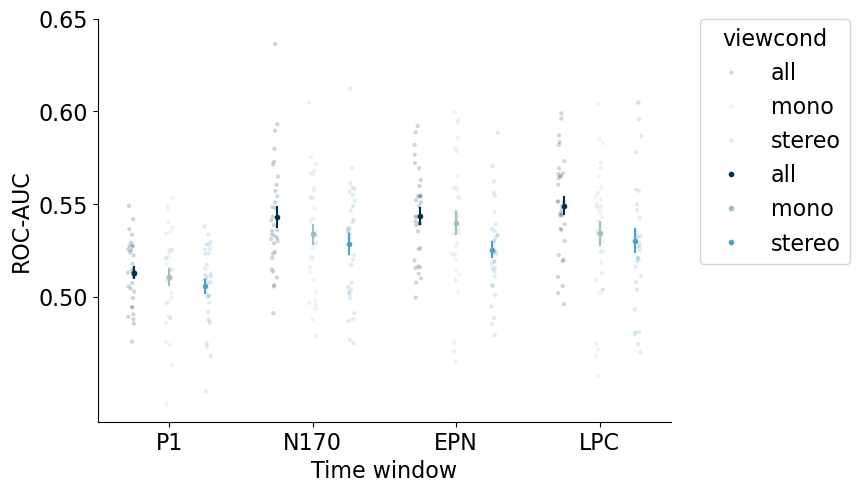

In [15]:
colors = COLORS()

fig, ax = plt.subplots(1, 1, figsize=(18.8 * cm, 13.3 * cm))

o = sns.stripplot(data=df_plt_mc, x="time_win", y="score", hue="viewcond", dodge=0.01,
                  size=3, jitter=0.075, alpha=0.2, palette = colors.COLDICT, ax=ax)
o = sns.pointplot(
    data=df_plt_mc.reset_index(),
    x="time_win",
    y="score",
    hue="viewcond",
    errorbar="se",
    dodge=0.5,
    palette=colors.COLDICT,
    linestyles="None",
    markers="o",
    markersize=2,
    err_kws={"linewidth": 1.5},
    ax=ax
    )

sns.move_legend(o, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
sns.despine()
o.set_xlabel("Time window")
o.set_ylabel("ROC-AUC")
# set y ticks:
yticks = np.arange(0.5, 0.7, 0.05)
_ = o.set_yticks(yticks)

fig.savefig(
    Path(paths.FIGURES, "decod_time-windows_all-vs-mono-vs-stereo.pdf"),
    transparent=True,  # bbox_inches="tight"
)

# Effect: contrast

## rmANOVA: performance ~ contrast * time window

In [16]:
# Now for all binary contrasts:
df_all = pd.DataFrame()

binary_contrasts = [("angry", "neutral"),
                    ("angry", "happy"),
                    ("angry", "surprised"),
                    ("happy", "neutral"),
                    ("happy", "surprised"),
                    ("surprised", "neutral")]

for c in binary_contrasts:
    data_dict_na = plotters.load_decod_res_per_viewcond(
        sub_list_str=sub_list_str,
        conditions=list(c),
        vc_list=[""],
        scoring="roc_auc_ovr",
    )
    if "" in data_dict_na:
        data_dict_na["all"] = data_dict_na.pop("")

    for tw in erp_windows:
        df_tmp = pd.DataFrame()
        tmin, tmax = erp_windows[tw]
        tidx = np.logical_and(data_dict_na["all"]["times"] >= tmin,
                              data_dict_na["all"]["times"] <= tmax)
        tmp_data = data_dict_na["all"]["scores"]
        tmp_data_tw = tmp_data[:, tidx].mean(axis=1).squeeze()
        df_tmp["score"] = tmp_data_tw
        df_tmp["time_win"] = tw
        df_tmp["contrast"] = "_vs_".join(c)
        df_tmp["sub_id"] = sub_list_str
        df_all = pd.concat([df_all, df_tmp]) if df_all.size else df_tmp

print(AnovaRM(df_all,
            depvar = "score",
            subject = "sub_id",
            within = ["time_win", "contrast"]).fit())

                      Anova
                  F Value  Num DF  Den DF  Pr > F
-------------------------------------------------
time_win          21.1332  3.0000  96.0000 0.0000
contrast           9.4310  5.0000 160.0000 0.0000
time_win:contrast  9.0234 15.0000 480.0000 0.0000



### Post-hoc test: main effect `time window`

In [17]:
df_posthoc_tw = (df_all
                    .groupby(["time_win", "sub_id"])
                    .agg({"score": "mean"})
                    .reset_index()
)


time_wins = list(erp_windows.keys())
pairwise_comps = [(time_wins[i], time_wins[j]) for i in range(len(time_wins))
                                            for j in range(len(time_wins)) if i < j]

posthoc_results = {}
for tw1, tw2 in pairwise_comps:
    t_stat, p_val = ttest_rel(df_posthoc_tw.query("time_win == @tw1")["score"],
                            df_posthoc_tw.query("time_win == @tw2")["score"])
    posthoc_results[f"{tw1} vs {tw2}"] = (t_stat, p_val)

p_vals = [p for _, p in posthoc_results.values()]
_, p_adj, _, _ = multipletests(p_vals, method="bonferroni")
for i, key in enumerate(posthoc_results):
    print(f"{key}: t = {posthoc_results[key][0]:.2f}, p = {p_adj[i]:.3f}")


P1 vs N170: t = -5.93, p = 0.000
P1 vs EPN: t = -6.42, p = 0.000
P1 vs LPC: t = -6.84, p = 0.000
N170 vs EPN: t = -0.15, p = 1.000
N170 vs LPC: t = -0.89, p = 1.000
EPN vs LPC: t = -0.84, p = 1.000


### Post-hoc test: main effect `contrast`

In [18]:
df_posthoc_c = (df_all
                    .groupby(["contrast", "sub_id"])
                    .agg({"score": "mean"})
                    .reset_index()
)


binary_contrasts_str = ["_vs_".join(c) for c in binary_contrasts]
pairwise_comps = [(binary_contrasts_str[i], binary_contrasts_str[j])
                  for i in range(len(binary_contrasts_str))
                  for j in range(len(binary_contrasts_str)) if i < j]

posthoc_results = {}
for c1, c2 in pairwise_comps:
    t_stat, p_val = ttest_rel(df_posthoc_c.query("contrast == @c1")["score"],
                            df_posthoc_c.query("contrast == @c2")["score"])
    posthoc_results[f"{c1} vs {c2}"] = (t_stat, p_val)

p_vals = [p for _, p in posthoc_results.values()]
_, p_adj, _, _ = multipletests(p_vals, method="bonferroni")
for i, key in enumerate(posthoc_results):
    print(f"{key}: t = {posthoc_results[key][0]:.2f}, p = {p_adj[i]:.3f}")


angry_vs_neutral vs angry_vs_happy: t = 1.89, p = 1.000
angry_vs_neutral vs angry_vs_surprised: t = 4.99, p = 0.000
angry_vs_neutral vs happy_vs_neutral: t = 5.04, p = 0.000
angry_vs_neutral vs happy_vs_surprised: t = 2.83, p = 0.119
angry_vs_neutral vs surprised_vs_neutral: t = 4.61, p = 0.001
angry_vs_happy vs angry_vs_surprised: t = 3.44, p = 0.025
angry_vs_happy vs happy_vs_neutral: t = 3.38, p = 0.029
angry_vs_happy vs happy_vs_surprised: t = 1.69, p = 1.000
angry_vs_happy vs surprised_vs_neutral: t = 2.77, p = 0.140
angry_vs_surprised vs happy_vs_neutral: t = -0.07, p = 1.000
angry_vs_surprised vs happy_vs_surprised: t = -1.90, p = 1.000
angry_vs_surprised vs surprised_vs_neutral: t = -0.86, p = 1.000
happy_vs_neutral vs happy_vs_surprised: t = -2.43, p = 0.316
happy_vs_neutral vs surprised_vs_neutral: t = -1.07, p = 1.000
happy_vs_surprised vs surprised_vs_neutral: t = 1.30, p = 1.000


### Post-hoc test: interaction effect `contrast` per `time window`

In [19]:

df_posthoc_chance = pd.DataFrame()

for time_win in time_wins:
  # Post-hoc pairwise t-tests for binary emotion contrasts:
  df_posthoc = (df_all
                  .query("time_win == @time_win")
                  .groupby(["sub_id", "contrast"])
                  .agg({"score": "mean", "contrast": "first"})
                  .reset_index(drop=True)
  )

  binary_contrasts_str = ["_vs_".join(c) for c in binary_contrasts]
  pairwise_comps = [(binary_contrasts_str[i], binary_contrasts_str[j])
                    for i in range(len(binary_contrasts_str))
                    for j in range(len(binary_contrasts_str)) if i < j]

  posthoc_results = {}
  for c1, c2 in pairwise_comps:
    t_stat, p_val = ttest_rel(df_posthoc.query("contrast == @c1")["score"],
                              df_posthoc.query("contrast == @c2")["score"])
    posthoc_results[f"{c1} vs {c2}"] = (t_stat, p_val)

  p_vals = [p for _, p in posthoc_results.values()] * len(time_wins)
  _, p_adj, _, _ = multipletests(p_vals, method="bonferroni")
  p_adj = p_adj[:len(posthoc_results)]

  print(f"\nTime window: {time_win}")
  for i, key in enumerate(posthoc_results):
    if p_adj[i] < alpha_lvl:
      print(f"{key}: t = {posthoc_results[key][0]:.2f}, p = {p_adj[i]:.3f}")

  print("\nContrasts vs chance:")
  posthoc_results = {}
  for c in binary_contrasts_str:
    t_stat, p_val = ttest_1samp(df_posthoc.query("contrast == @c")["score"],
                              0.5)
    posthoc_results[c] = (t_stat, p_val)

  p_vals = [p for _, p in posthoc_results.values()] * len(time_wins)
  _, p_adj, _, _ = multipletests(p_vals, method="bonferroni")
  p_adj = p_adj[:len(posthoc_results)]

  for i, c in enumerate(posthoc_results):
    if p_adj[i] < alpha_lvl:
      print(f"{c} vs chance: t = {posthoc_results[c][0]:.2f}, p = {p_adj[i]:.5f}")

    df_ttmp = pd.DataFrame({"contrast": c,
                              "time_win": time_win,
                              "p_val": p_adj[i],
                              "sign": p_adj[i] < alpha_lvl},
                              index=[0])
    df_posthoc_chance = pd.concat([df_posthoc_chance, df_ttmp]) if df_posthoc_chance.size else df_ttmp


Time window: P1

Contrasts vs chance:
happy_vs_surprised vs chance: t = 4.81, p = 0.00083

Time window: N170
angry_vs_neutral vs angry_vs_surprised: t = 6.92, p = 0.000
angry_vs_neutral vs happy_vs_neutral: t = 7.04, p = 0.000
angry_vs_neutral vs happy_vs_surprised: t = 5.32, p = 0.000
angry_vs_neutral vs surprised_vs_neutral: t = 6.86, p = 0.000
angry_vs_happy vs happy_vs_neutral: t = 3.72, p = 0.046

Contrasts vs chance:
angry_vs_neutral vs chance: t = 9.43, p = 0.00000
angry_vs_happy vs chance: t = 5.87, p = 0.00004
angry_vs_surprised vs chance: t = 4.96, p = 0.00054
happy_vs_neutral vs chance: t = 3.72, p = 0.01842
happy_vs_surprised vs chance: t = 5.18, p = 0.00028
surprised_vs_neutral vs chance: t = 4.40, p = 0.00269

Time window: EPN

Contrasts vs chance:
angry_vs_neutral vs chance: t = 7.14, p = 0.00000
angry_vs_happy vs chance: t = 7.33, p = 0.00000
angry_vs_surprised vs chance: t = 5.29, p = 0.00020
happy_vs_neutral vs chance: t = 3.97, p = 0.00911
happy_vs_surprised vs chan

### Post-hoc test: main effect `time window` per `contrast`

In [20]:
for c in binary_contrasts:
  contrast = "_vs_".join(c)
  # Post-hoc pairwise t-tests for binary emotion contrasts:
  df_posthoc = (df_all
                  .query("contrast == @contrast")
                  .groupby(["sub_id", "time_win"])
                  .agg({"score": "mean", "time_win": "first"})
                  .reset_index(drop=True)
  )

  pairwise_comps = [(time_wins[i], time_wins[j])
                    for i in range(len(time_wins))
                    for j in range(len(time_wins)) if i < j]

  posthoc_results = {}
  for tw1, tw2 in pairwise_comps:
    t_stat, p_val = ttest_rel(df_posthoc.query("time_win == @tw1")["score"],
                              df_posthoc.query("time_win == @tw2")["score"])
    posthoc_results[f"{tw1} vs {tw2}"] = (t_stat, p_val)

  p_vals = [p for _, p in posthoc_results.values()]
  _, p_adj, _, _ = multipletests(p_vals, method="bonferroni")

  print(f"\nContrast: {contrast}")
  for i, key in enumerate(posthoc_results):
    if p_adj[i] < alpha_lvl:
      print(f"{key}: t = {posthoc_results[key][0]:.2f}, p = {p_adj[i]:.3f}")


Contrast: angry_vs_neutral
P1 vs N170: t = -9.78, p = 0.000
P1 vs EPN: t = -5.70, p = 0.000
P1 vs LPC: t = -7.20, p = 0.000
N170 vs EPN: t = 3.47, p = 0.009

Contrast: angry_vs_happy
P1 vs N170: t = -5.57, p = 0.000
P1 vs EPN: t = -5.76, p = 0.000
P1 vs LPC: t = -6.74, p = 0.000

Contrast: angry_vs_surprised

Contrast: happy_vs_neutral
P1 vs LPC: t = -3.58, p = 0.007

Contrast: happy_vs_surprised

Contrast: surprised_vs_neutral
P1 vs LPC: t = -4.50, p = 0.001


## Plot: Performance per time window & contrast

(0.4, 0.75)

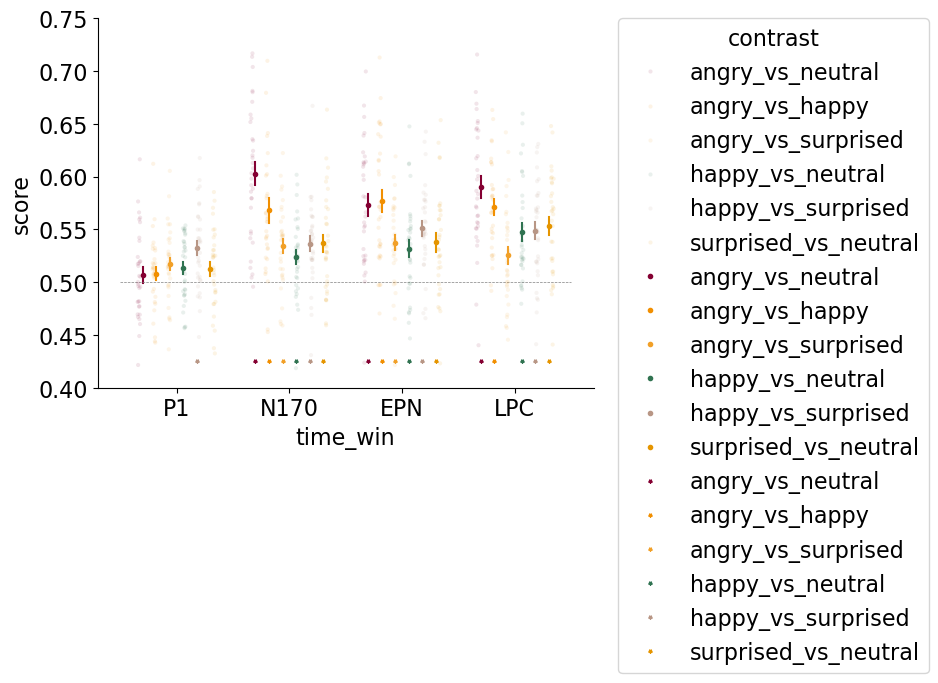

In [21]:
colors = COLORS()


o = sns.stripplot(data=df_all, x="time_win", y="score", hue="contrast", dodge=True,
                  size=3, jitter=0.075, palette = colors.COLDICT,
                  alpha=0.1)
o = sns.pointplot(
    data=df_all.reset_index(),
    x="time_win",
    y="score",
    hue="contrast",
    errorbar="se",
    dodge=0.6,
    palette=colors.COLDICT,
    linestyles="None",
    markers="o",
    markersize=2,
    err_kws={"linewidth": 1.5},
    )

df_posthoc_chance["y"] = df_posthoc_chance.apply(lambda x: 0.425 if x["sign"] else -0.4, axis=1)

o = sns.pointplot(data=df_posthoc_chance, x="time_win", y="y",
                  hue="contrast", dodge=0.6, markers="*", markersize=2, linestyles="None", palette=colors.COLDICT)

sns.move_legend(o, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
sns.despine()
o.hlines(0.5, -0.5, 3.5, linestyles="dashed", linewidth=0.5, color="grey")
o.set_ylim(0.4, 0.75)

# Decoding the viewing condition
Now we see whether we can decode (across all emotions) whether we can decode in which `viewing condition` a trial was shown.

Found 4 significant clusters for viewing condition 'viewcond'.
Significant cluster: 114.000 - 714.000
Significant cluster: 784.000 - 824.000
Significant cluster: 854.000 - 904.000
Significant cluster: 974.000 - 1000.000


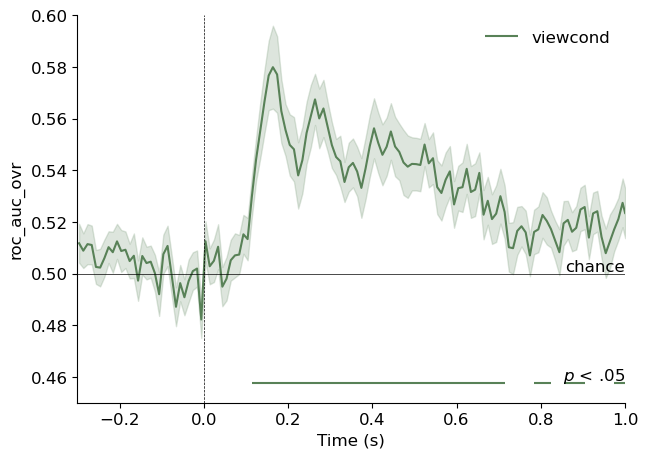

In [8]:
data_dict_vc = plotters.load_decod_res_per_viewcond(
    sub_list_str=sub_list_str,
    conditions=["mono", "stereo"],
    vc_list=[""],
    scoring="roc_auc_ovr",
)
data_dict_vc["viewcond"] = data_dict_vc.pop("")

fig, ax = plt.subplots(1, figsize=(18.8 * cm, 13.3 * cm))
plotters.prep_and_plot_from_data(
    data_dict=data_dict_vc,
    subsets=["viewcond"],
    ax=ax,
    chancelvl=0.5,
    ylims=(0.45, 0.6),
    scoring="roc_auc_ovr",
)

fig.tight_layout()
fig.subplots_adjust(left=0.16, bottom=0.16, right=0.9, top=0.9)

fig.savefig(
    Path(paths.FIGURES, "decod_mono-vs-stereo_emo-all.pdf"),
    transparent=True,  # bbox_inches="tight"
)

In [ ]:
# Overall:
print("All:")
_ = plotters.get_max_decod_score_and_time(data_dict_vc["viewcond"])

# grab the peak times:
peaktimes_vc = data_dict_vc["viewcond"]["times"][data_dict_vc["viewcond"]["scores"].argmax(axis=1)]


All:
Peak mean: M = 0.65, SD = 0.07, 95% CI [0.62, 0.67]
Peak time: M = 184.00, SD = 204.17, 95% CI [114.34, 253.66]


In [22]:
df_plt_mc = pd.DataFrame()

timings = TIMINGS()
erp_windows = timings.ERP_WINDOWS


tmp_data = data_dict_vc["viewcond"]["scores"]
times = data_dict_vc["viewcond"]["times"]

df_tmp = pd.DataFrame()

for tw in erp_windows:
    tmin, tmax = erp_windows[tw]
    tidx = np.logical_and(times >= tmin,
                            times <= tmax)
    tmp_data_tw = tmp_data[:, tidx].mean(axis=1).squeeze()
    df_tmp[tw] = tmp_data_tw

df_aov_tmp = (pd.melt(df_tmp, var_name="time_win", value_name="score", ignore_index=False)
                .reset_index(names="sub_id"))
print(AnovaRM(df_aov_tmp,
            depvar = "score",
            subject = "sub_id",
            within = ["time_win"]).fit())


time_wins = list(erp_windows.keys())
pairwise_comps = [(time_wins[i], time_wins[j]) for i in range(len(time_wins))
                                            for j in range(len(time_wins)) if i < j]

posthoc_results = {}
for tw1, tw2 in pairwise_comps:
    t_stat, p_val = ttest_rel(df_aov_tmp.query("time_win == @tw1")["score"],
                            df_aov_tmp.query("time_win == @tw2")["score"])
    posthoc_results[f"{tw1} vs {tw2}"] = (t_stat, p_val)

p_vals = [p for _, p in posthoc_results.values()]
_, p_adj, _, _ = multipletests(p_vals, method="bonferroni")
for i, key in enumerate(posthoc_results):
    print(f"{key}: t = {posthoc_results[key][0]:.2f}, p = {p_adj[i]:.3f}")


df_plt = (df_aov_tmp
        .assign(time_win = pd.Categorical(df_aov_tmp["time_win"], categories=time_wins, ordered=True))
        .sort_values(by=["time_win"])
        .reset_index(drop=True)
)
df_plt["viewcond"] = "all"

df_plt_mc = pd.concat([df_plt_mc, df_plt]) if df_plt_mc.size else df_plt

                Anova
         F Value Num DF  Den DF Pr > F
--------------------------------------
time_win 16.6619 3.0000 96.0000 0.0000

P1 vs N170: t = -5.56, p = 0.000
P1 vs EPN: t = -5.57, p = 0.000
P1 vs LPC: t = -3.15, p = 0.021
N170 vs EPN: t = 0.84, p = 1.000
N170 vs LPC: t = 3.34, p = 0.013
EPN vs LPC: t = 2.45, p = 0.121


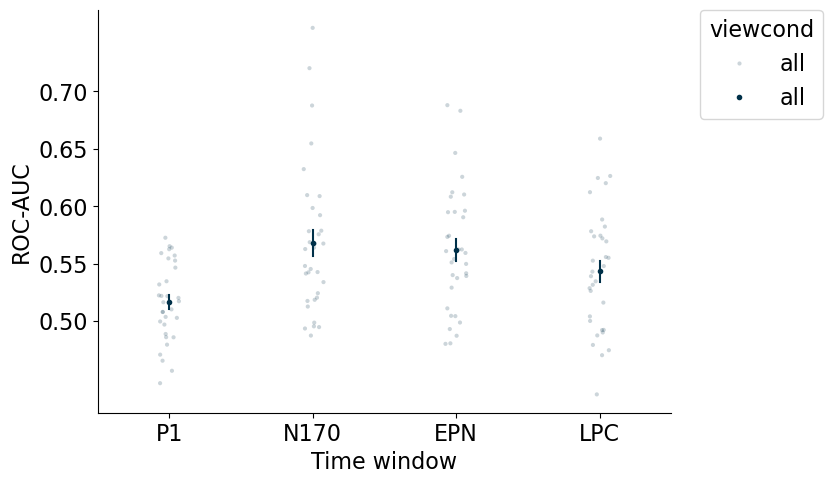

In [26]:
colors = COLORS()

fig, ax = plt.subplots(1, 1, figsize=(18.8 * cm, 13.3 * cm))

o = sns.stripplot(data=df_plt_mc, x="time_win", y="score", hue="viewcond",
                  size=3, jitter=0.075, alpha=0.2, palette = colors.COLDICT, ax=ax)
o = sns.pointplot(
    data=df_plt_mc.reset_index(),
    x="time_win",
    y="score",
    hue="viewcond",
    errorbar="se",
    palette=colors.COLDICT,
    linestyles="None",
    markers="o",
    markersize=2,
    err_kws={"linewidth": 1.5},
    ax=ax
    )

sns.move_legend(o, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
sns.despine()
o.set_xlabel("Time window")
o.set_ylabel("ROC-AUC")
# set y ticks:
yticks = np.arange(0.5, 0.75, 0.05)
_ = o.set_yticks(yticks)



# Decoding face identity

Found 3 significant clusters for viewing condition 'all'.
Significant cluster: 84.000 - 624.000
Significant cluster: 644.000 - 904.000
Significant cluster: 924.000 - 954.000


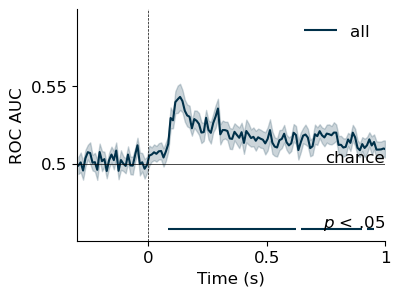

In [28]:
data_dict_id = plotters.load_decod_res_per_viewcond(
    sub_list_str=sub_list_str,
    conditions=["id1", "id2", "id3"],
    vc_list=["", "mono", "stereo"],
    scoring="roc_auc_ovr",
)
data_dict_id["all"] = data_dict_id.pop("")

fig, ax = plt.subplots(1, figsize=(9.3 * cm, 7 * cm))
plotters.prep_and_plot_from_data(data_dict_id, subsets=["all"], ax=ax, chancelvl=0.5, ylims=(0.45, 0.6))

# set xticks to only 0, 0.5 and 1
ax.set_xticks([0, 0.5, 1])
ax.set_xticklabels([0, 0.5, 1])
ax.set_yticks([0.5, 0.55])
ax.set_yticklabels([0.5, 0.55])

fig.tight_layout()
fig.subplots_adjust(left=0.08, bottom=0.08, right=0.92, top=0.92)

fig.savefig(
    Path(paths.FIGURES, "decod_identity_emo-all.pdf"),
    transparent=True,  # bbox_inches="tight"
)

In [35]:
# Overall:
print("All:")
_ = plotters.get_max_decod_score_and_time(data_dict_id["all"])

# grab the peak times:
peaktimes_id = data_dict_id["all"]["times"][data_dict_id["all"]["scores"].argmax(axis=1)]

# run paired t-test:
t, p = stats.ttest_rel(peaktimes_vc, peaktimes_id)
print(f"Peak time ID decoding vs Viewcond decoding (paired t test): t({len(peaktimes_vc)-1}) = {t:.2f}, p = {p:.3f}")


All:
Peak mean: M = 0.60, SD = 0.03, 95% CI [0.59, 0.61]
Peak time: M = 134.00, SD = 244.62, 95% CI [50.54, 217.46]
Peak time ID decoding vs Viewcond decoding (paired t test): t(32) = 0.88, p = 0.386


In [45]:
df_plt_mc = pd.DataFrame()

timings = TIMINGS()
erp_windows = timings.ERP_WINDOWS


tmp_data = data_dict_id["all"]["scores"]
times = data_dict_id["all"]["times"]

df_tmp = pd.DataFrame()

for tw in erp_windows:
    tmin, tmax = erp_windows[tw]
    tidx = np.logical_and(times >= tmin,
                            times <= tmax)
    tmp_data_tw = tmp_data[:, tidx].mean(axis=1).squeeze()
    df_tmp[tw] = tmp_data_tw

df_aov_tmp = (pd.melt(df_tmp, var_name="time_win", value_name="score", ignore_index=False)
                .reset_index(names="sub_id"))
print(AnovaRM(df_aov_tmp,
            depvar = "score",
            subject = "sub_id",
            within = ["time_win"]).fit())


time_wins = list(erp_windows.keys())
pairwise_comps = [(time_wins[i], time_wins[j]) for i in range(len(time_wins))
                                            for j in range(len(time_wins)) if i < j]

posthoc_results = {}
for tw1, tw2 in pairwise_comps:
    t_stat, p_val = ttest_rel(df_aov_tmp.query("time_win == @tw1")["score"],
                            df_aov_tmp.query("time_win == @tw2")["score"])
    posthoc_results[f"{tw1} vs {tw2}"] = (t_stat, p_val)

p_vals = [p for _, p in posthoc_results.values()]
_, p_adj, _, _ = multipletests(p_vals, method="bonferroni")
for i, key in enumerate(posthoc_results):
    print(f"{key}: t = {posthoc_results[key][0]:.2f}, p = {p_adj[i]:.3f}")


df_plt = (df_aov_tmp
        .assign(time_win = pd.Categorical(df_aov_tmp["time_win"], categories=time_wins, ordered=True))
        .sort_values(by=["time_win"])
        .reset_index(drop=True)
)
df_plt["viewcond"] = "all"

df_plt_mc = pd.concat([df_plt_mc, df_plt]) if df_plt_mc.size else df_plt

                Anova
         F Value Num DF  Den DF Pr > F
--------------------------------------
time_win  3.6186 3.0000 96.0000 0.0159

P1 vs N170: t = -1.00, p = 1.000
P1 vs EPN: t = 0.11, p = 1.000
P1 vs LPC: t = 2.10, p = 0.261
N170 vs EPN: t = 1.28, p = 1.000
N170 vs LPC: t = 3.49, p = 0.009
EPN vs LPC: t = 2.12, p = 0.251


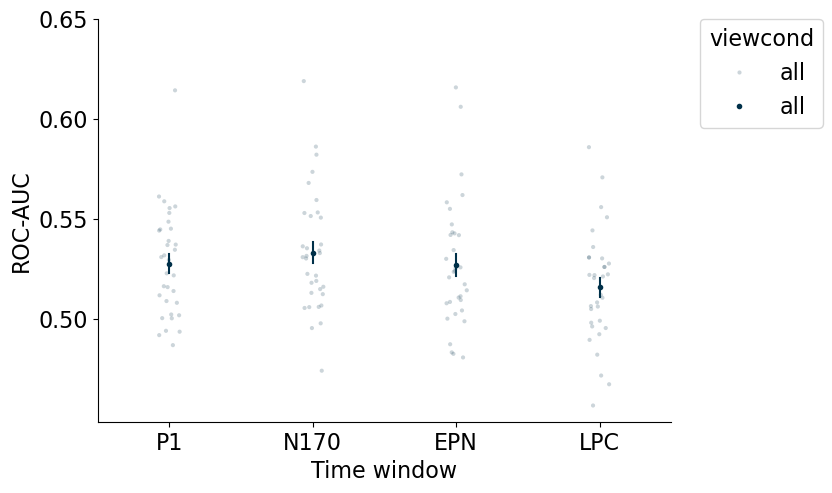

In [38]:
colors = COLORS()

fig, ax = plt.subplots(1, 1, figsize=(18.8 * cm, 13.3 * cm))

o = sns.stripplot(data=df_plt_mc, x="time_win", y="score", hue="viewcond",
                  size=3, jitter=0.075, alpha=0.2, palette = colors.COLDICT, ax=ax)
o = sns.pointplot(
    data=df_plt_mc.reset_index(),
    x="time_win",
    y="score",
    hue="viewcond",
    errorbar="se",
    palette=colors.COLDICT,
    linestyles="None",
    markers="o",
    markersize=2,
    err_kws={"linewidth": 1.5},
    ax=ax
    )

sns.move_legend(o, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
sns.despine()
o.set_xlabel("Time window")
o.set_ylabel("ROC-AUC")
# set y ticks:
yticks = np.arange(0.5, 0.65, 0.05)
_ = o.set_yticks(yticks)


Found 2 significant clusters for viewing condition 'mono'.
Significant cluster: 104.000 - 174.000
Significant cluster: 194.000 - 224.000
Found 2 significant clusters for viewing condition 'stereo'.
Significant cluster: 74.000 - 444.000
Significant cluster: 554.000 - 664.000


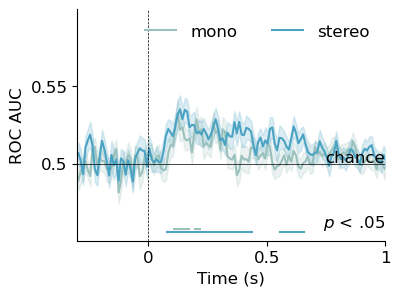

In [13]:
fig, ax = plt.subplots(1, figsize=(9.3 * cm, 7 * cm))
plotters.prep_and_plot_from_data(data_dict_id, subsets=["mono", "stereo"], ax=ax, chancelvl=0.5, ylims=(0.45, 0.6))

# set xticks to only 0, 0.5 and 1
ax.set_xticks([0, 0.5, 1])
ax.set_xticklabels([0, 0.5, 1])
ax.set_yticks([0.5, 0.55])
ax.set_yticklabels([0.5, 0.55])

fig.tight_layout()
fig.subplots_adjust(left=0.08, bottom=0.08, right=0.92, top=0.92)

fig.savefig(
    Path(paths.FIGURES, "decod_identity_emo-mono-vs-stereo.pdf"),
    transparent=True,  # bbox_inches="tight"
)

# Plot: Spatial Patterns

In [35]:
def load_and_normalize_patterns(sub_list_str, contrast, viewcond=""):
    """
    Load and normalize EEG patterns for a set of subjects based on a specified contrast and view condition.

    This function loads EEG patterns for the given subjects, normalizes the patterns by their L2 norm,
    and calculates the unbiased average of these normalized patterns. The resulting averaged pattern
    is used to create an `EvokedArray` object, representing the event-related activity across subjects.

    Parameters
    ----------
    sub_list_str : str
        A string specifying the list of subjects to load.
    contrast : str
        The contrast condition for loading EEG patterns (e.g., "angry_vs_neutral").
    viewcond : str, optional
        The view condition for loading patterns. Can be "mono", "stereo", or "all" (same as "", which pools across mono
        and stereo trials). Default is "".

    Returns
    -------
    sub_patterns_evo : mne.EvokedArray
        An `EvokedArray` object containing the averaged and normalized EEG patterns across subjects.
    pat_times : np.ndarray
        An array of time points corresponding to the EEG patterns.

    Notes
    -----
    - The function uses L2 normalization to ensure unbiased averaging of patterns across subjects.
    - The `EvokedArray` is built using the montage `easycap-M1` with EEG channel information
      derived from the loaded data.

    """
    if viewcond == "all":
        viewcond = ""

    sub_patterns, pat_times = plotters.load_patterns(
        sub_list_str,
        contrast_str=contrast,
        viewcond=viewcond,
        scoring="roc_auc_ovr"
    )

    sub_patterns = sub_patterns[:, :, :]
    sub_patterns_norm = np.zeros_like(sub_patterns)
    # normalize them by L2 norm to allow for unbiased averages:
    for sub in range(sub_patterns.shape[0]):
        for time in range(sub_patterns.shape[-1]):
            sub_patterns_norm[sub, :, time] = sub_patterns[sub, :, time] / l2norm(sub_patterns[sub, :, time])
    sub_patterns_avg = sub_patterns_norm.copy().mean(axis=0)
    sub_patterns_avg_norm = np.stack(
        [sub_patterns_avg[:, ii] / l2norm(sub_patterns_avg[:, ii]) for ii in range(sub_patterns_avg.shape[-1])],
        axis=-1,
    )

    # Build new pseudo Evoke obj:
    dummy_epos_info = plotters.get_info()
    easycap_montage = mne.channels.make_standard_montage("easycap-M1")
    info = mne.create_info(ch_names=dummy_epos_info.ch_names,
                           sfreq=(1 / np.median(np.diff(pat_times))),
                           ch_types="eeg")
    info.set_montage(easycap_montage)
    sub_patterns_evo = EvokedArray(sub_patterns_avg_norm, info, tmin=pat_times[0])

    return sub_patterns_evo, pat_times

[[<Axes: > <Axes: > <Axes: >]
 [<Axes: > <Axes: > <Axes: >]
 [<Axes: > <Axes: > <Axes: >]]


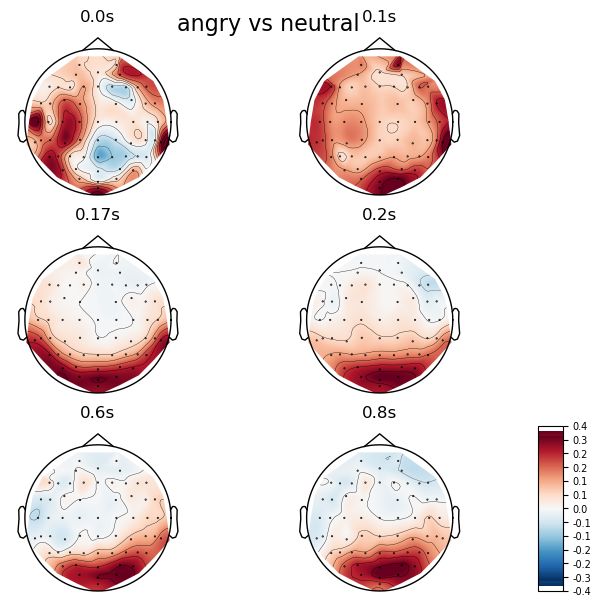

In [ ]:
contrast = "angry_vs_neutral"
times_plot = [0.0, 0.1, 0.17, 0.2, 0.6, 0.8]
save_fig = True

sub_patterns_evo, pat_times = load_and_normalize_patterns(sub_list_str, contrast, viewcond="all")

fig, ax = plt.subplots(3, 3, figsize=(16.6 * cm, 15 * cm), gridspec_kw={"width_ratios": [10, 10, 1]})
aaxx = [[0, 0], [0, 1], [1, 0], [1, 1], [2, 0], [2, 1]]
print(ax)

for tt, axi in zip(times_plot, aaxx, strict=True):
    t_plot = [tt]
    plt_load = sub_patterns_evo.plot_topomap(
        times=t_plot,
        scalings=1,
        units="",
        cmap="RdBu_r",
        # vmin = -0.3,  # noqa: ERA001
        # vmax=0.3,  # noqa: ERA001
        contours=10,
        ch_type="eeg",
        extrapolate="local",
        axes=[ax[axi[0], axi[1]], ax[2, 2]],
        show=False,
    )
    ax[axi[0], axi[1]].set_title(f"{tt}s", fontsize=12)
# cb = ax.figure.colorbar(plt_load, ax=ax_cb)
fig.delaxes(ax[0][2])
fig.delaxes(ax[1][2])

fig.suptitle(contrast.replace("_", " "), fontsize=16)
plt.show()


if save_fig:
    # save it:
    fig.savefig(Path(paths.FIGURES, f"topomap_decod_{contrast.replace('_', '-')}.pdf"), transparent=True, bbox_inches="tight")

## Source reconstruction

In [52]:
def get_stc(sub_id, contrast):
    """Load the Source timecourses from disk."""
    paths = PATHS()
    fpath = Path(paths.DATA_04_DECOD_SENSORSPACE, contrast, "roc_auc_ovr", "patterns", "src_timecourses", f"{sub_id}")
    stc = mne.read_source_estimate(fpath)
    return stc


def prep_mean_stc(stcs):
    """Normalize and average source timecourses across participants."""
    stc_avg = np.array([st.data for st in stcs])

    # normalize per participant and time step by L2 norm to allow for unbiased averages:
    stc_avg_norm = np.zeros_like(stc_avg)
    for sub in range(stc_avg.shape[0]):
        stc_avg_norm[sub, :, :] = stc_avg[sub, :, :] / sum(stc_avg[sub, :, :])
        # for time in range(stc_avg.shape[-1]):
        #    stc_avg_norm[sub, :, time] = stc_avg[sub, :, time] / sum(stc_avg[sub, :, time])

    # avg across participants
    stc_mean_data = np.mean(stc_avg_norm, axis=0)
    stc_mean = stcs[0].copy()  # use as template to get the metadata
    stc_mean.data = stc_mean_data
    stc_mean.subject = "fsaverage"
    return stc_mean


def plot_stc(stc, time=0.2):
    """Plot the source timecourse at a given time point."""
    fs_dir = fetch_fsaverage(verbose=False)
    subjects_dir = Path(fs_dir).parent
    kwargs = dict(
        initial_time=time,
        hemi="rh",
        subjects_dir=subjects_dir,
        size=(600, 600),  # clim={'lims':(50, 75, 95), 'kind': 'percent'},  # (0, 10, 20)},
        colormap="hot",
        # transparent=False,
        background="white",
        smoothing_steps=7,
        backend="matplotlib",
        views="par",
        clim={"kind": "percent", "lims": (95, 97.5, 99.9)},
    )
    stc.plot(**kwargs)

In [61]:
# Prepare the source timecourses:
stcs = {}
contrasts = ["mono_vs_stereo", "angry_vs_neutral", "angry_vs_happy", "happy_vs_neutral"]
for c in contrasts:
    stcs[c] = []
    for sub_id in sub_list_str:
        stc = get_stc(sub_id, c)
        stcs[c].append(stc)

Using control points [0.0001819  0.00019472 0.00024581]
Octahedron subdivision grade 6
    Triangle neighbors and vertex normals...
Loading geometry from /u/fklotzsche/mne_data/MNE-fsaverage-data/fsaverage/surf/rh.sphere...
Setting up the triangulation for the decimated surface...
    7 smooth iterations done.


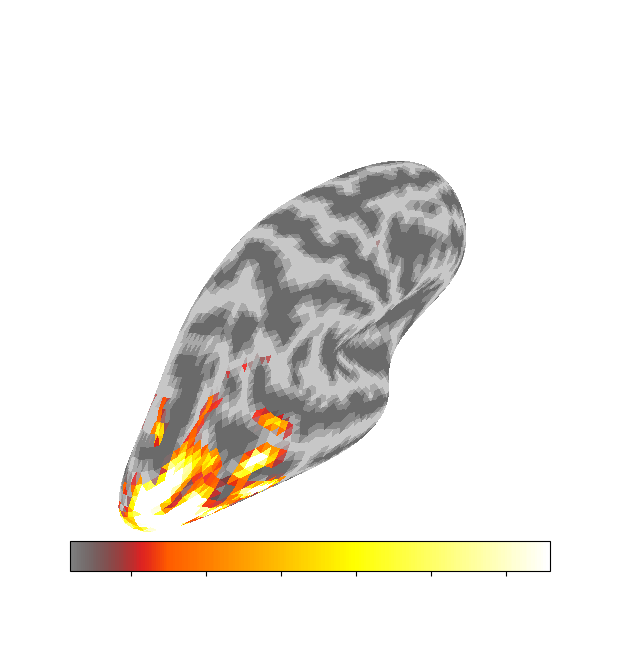

Using control points [0.0001797  0.00019271 0.00024013]
Octahedron subdivision grade 6
    Triangle neighbors and vertex normals...
Loading geometry from /u/fklotzsche/mne_data/MNE-fsaverage-data/fsaverage/surf/rh.sphere...
Setting up the triangulation for the decimated surface...
    7 smooth iterations done.


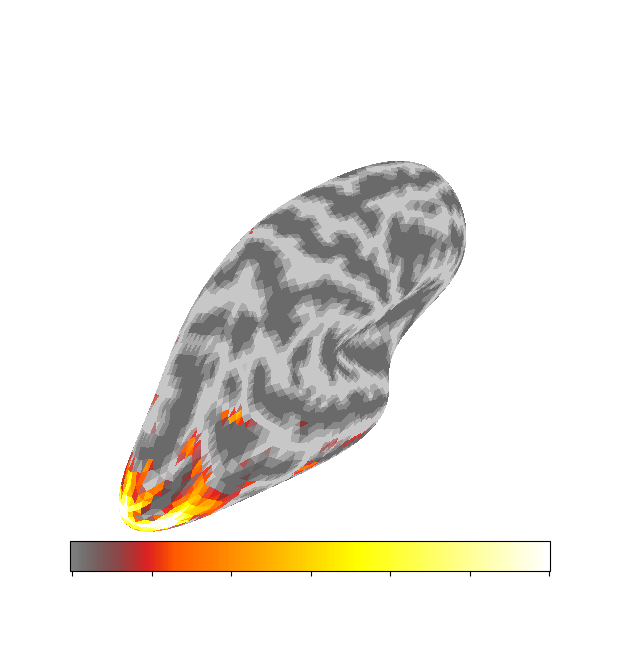

Using control points [0.00017946 0.00019331 0.0002475 ]
Octahedron subdivision grade 6
    Triangle neighbors and vertex normals...
Loading geometry from /u/fklotzsche/mne_data/MNE-fsaverage-data/fsaverage/surf/rh.sphere...
Setting up the triangulation for the decimated surface...
    7 smooth iterations done.


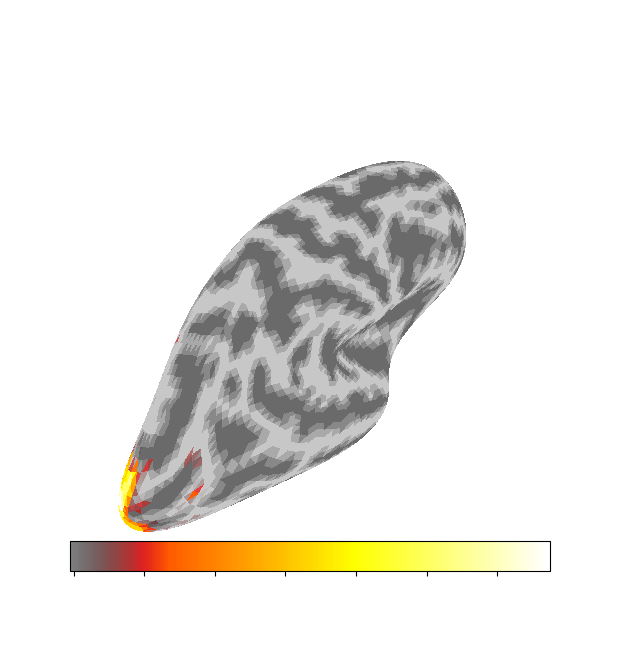

Using control points [0.00017943 0.00019221 0.00023983]
Octahedron subdivision grade 6
    Triangle neighbors and vertex normals...
Loading geometry from /u/fklotzsche/mne_data/MNE-fsaverage-data/fsaverage/surf/rh.sphere...
Setting up the triangulation for the decimated surface...
    7 smooth iterations done.


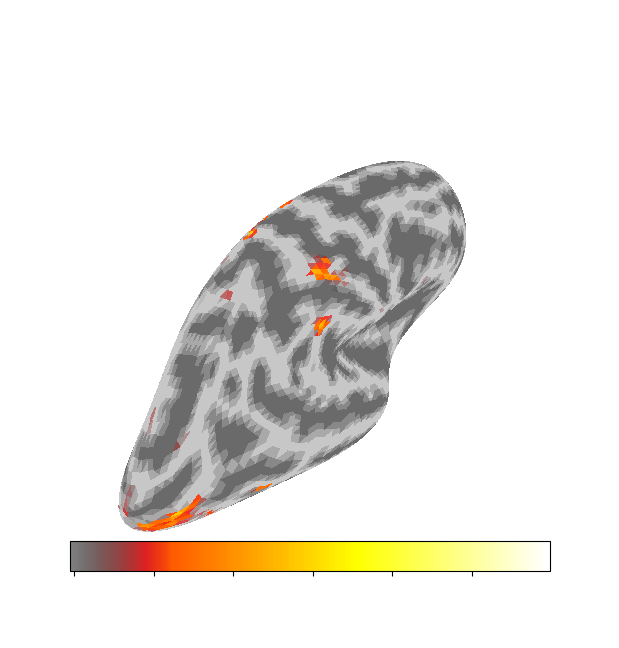

In [62]:
for c in contrasts:
    stc_m = prep_mean_stc(stcs[c])
    plot_stc(stc_m, 0.170)